# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2016


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2016-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    116,986    4,719   2,457   2,030   2,441
  1           9thStreet    118,592    4,469   2,974   2,582   2,955
  2          14thStreet    226,419    8,953   4,926   4,175   5,408
  3          23rdStreet    209,443    9,348   2,700   2,189   3,690
  4          33rdStreet    831,037   34,541  14,418  11,794  21,852
  5     UPTOWN SUBTOTAL  1,502,477   62,030  27,475  22,770  36,346
  6                 WTC  1,067,421   49,361  10,990   8,516  16,014
  7   NEW YORK SUBTOTAL  2,569,898  111,391  38,465  31,286  52,360,
                       0          1        2       3       4        5
  0               Newark    579,100   25,934   7,845   5,568    9,639
  1             Harrison    160,111    7,127   2,325   1,453    2,906
  2       Journal Square    601,555   25,169  11,071   8,538   12,651
  3         Grove Street    434,497   18,383   7,929   5,913    8,004
  4       Exchange Place    343,44

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

0          1        2        3       4       5  \
0    Christopher Street    116,986    4,719    2,457   2,030   2,441   
1             9thStreet    118,592    4,469    2,974   2,582   2,955   
2            14thStreet    226,419    8,953    4,926   4,175   5,408   
3            23rdStreet    209,443    9,348    2,700   2,189   3,690   
4            33rdStreet    831,037   34,541   14,418  11,794  21,852   
..                  ...        ...      ...      ...     ...     ...   
4        Exchange Place    396,163   16,523    5,525   4,211   4,719   
5      Pavonia/ Newport    468,520   18,783    8,414   5,999   8,018   
6               Hoboken    631,220   26,687    8,673   5,132   6,891   
7   NEW JERSEY SUBTOTAL  3,541,669  144,092   58,994  41,436  55,041   
8         MONTHLY TOTAL  6,351,524  258,947  101,486  76,750  99,208   

          date  
0   2016-01-01  
1   2016-01-01  
2   2016-01-01  
3   2016-01-01  
4   2016-01-01  
..         ...  
4   2016-12-01  
5   2016-12-01  
6   2016-12-01  
7   2016-12-01  
8   2016-12-01  

[204 rows x 7 columns]

In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

station    total  avg weekday  avg sat  avg sun  avg holiday  \
0    Christopher Street   116986         4719     2457     2030         2441   
1             9thStreet   118592         4469     2974     2582         2955   
2            14thStreet   226419         8953     4926     4175         5408   
3            23rdStreet   209443         9348     2700     2189         3690   
4            33rdStreet   831037        34541    14418    11794        21852   
..                  ...      ...          ...      ...      ...          ...   
4        Exchange Place   396163        16523     5525     4211         4719   
5      Pavonia/ Newport   468520        18783     8414     5999         8018   
6               Hoboken   631220        26687     8673     5132         6891   
7   NEW JERSEY SUBTOTAL  3541669       144092    58994    41436        55041   
8         MONTHLY TOTAL  6351524       258947   101486    76750        99208   

         month  
0   2016-01-01  
1   2016-01-01  
2   2016-01-01  
3   2016-01-01  
4   2016-01-01  
..         ...  
4   2016-12-01  
5   2016-12-01  
6   2016-12-01  
7   2016-12-01  
8   2016-12-01  

[204 rows x 7 columns]

In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

station  avg daily  total weekday  total sat  total sun  \
0    Christopher Street       3774          89669      12287      10148   
1             9thStreet       3826          84903      14869      12910   
2            14thStreet       7304         170099      24629      20876   
3            23rdStreet       6756         177618      13501      10945   
4            33rdStreet      26808         656273      72090      58969   
..                  ...        ...            ...        ...        ...   
4        Exchange Place      12779         346976      27623      16845   
5      Pavonia/ Newport      15114         394435      42070      23997   
6               Hoboken      20362         560437      43363      20529   
7   NEW JERSEY SUBTOTAL     114247        3025919     294962     165747   
8         MONTHLY TOTAL     204888        5437888     507429     306999   

    total holiday       month  
0            4882  2016-01-01  
1            5910  2016-01-01  
2           10815  2016-01-01  
3            7379  2016-01-01  
4           43705  2016-01-01  
..            ...         ...  
4            4719  2016-12-01  
5            8018  2016-12-01  
6            6891  2016-12-01  
7           55041  2016-12-01  
8           99208  2016-12-01  

[204 rows x 7 columns]

In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2016-01-01 Christopher Street        3774         4719     2457     2030   
           9thStreet                 3826         4469     2974     2582   
           14thStreet                7304         8953     4926     4175   
           23rdStreet                6756         9348     2700     2189   
           33rdStreet               26808        34541    14418    11794   
...                                   ...          ...      ...      ...   
2016-12-01 Exchange Place           12779        16523     5525     4211   
           Pavonia/ Newport         15114        18783     8414     5999   
           Hoboken                  20362        26687     8673     5132   
           NEW JERSEY SUBTOTAL     114247       144092    58994    41436   
           MONTHLY TOTAL           204888       258947   101486    76750   

                                avg holiday    total  total weekday  \
month      station                                                    
2016-01-01 Christopher Street          2441   116986          89669   
           9thStreet                   2955   118592          84903   
           14thStreet                  5408   226419         170099   
           23rdStreet                  3690   209443         177618   
           33rdStreet                 21852   831037         656273   
...                                     ...      ...            ...   
2016-12-01 Exchange Place              4719   396163         346976   
           Pavonia/ Newport            8018   468520         394435   
           Hoboken                     6891   631220         560437   
           NEW JERSEY SUBTOTAL        55041  3541669        3025919   
           MONTHLY TOTAL              99208  6351524        5437888   

                                total sat  total sun  total holiday  
month      station                                                   
2016-01-01 Christopher Street       12287      10148           4882  
           9thStreet                14869      12910           5910  
           14thStreet               24629      20876          10815  
           23rdStreet               13501      10945           7379  
           33rdStreet               72090      58969          43705  
...                                   ...        ...            ...  
2016-12-01 Exchange Place           27623      16845           4719  
           Pavonia/ Newport         42070      23997           8018  
           Hoboken                  43363      20529           6891  
           NEW JERSEY SUBTOTAL     294962     165747          55041  
           MONTHLY TOTAL           507429     306999          99208  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

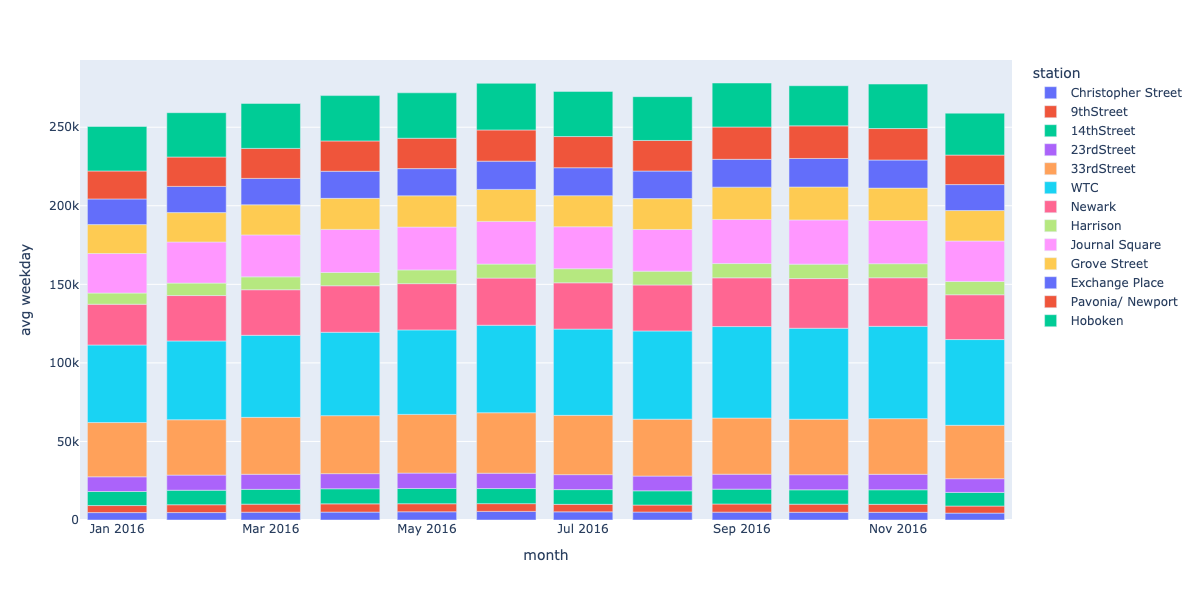

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))